# Running the Quantum Volume Algorithm
This example walks through the steps of running the quantum volume algorithm on square matrices. It is intended to mirror Algorithm 1 of https://arxiv.org/pdf/1811.12926.pdf. In general, we will generate a model circuit, classically compute its Heavy Output Group, then run various samplers (currently, ideal and noisy simulators) to evaluate how often they generate Heavy results.

In [24]:
# This cell sets up the parameters for the quantum volume algorithm.
# Feel free to mess with these!
import cirq

import sys
sys.path.insert(1, '/Users/villela/Projects/cirq-internal/')
import cirq_internal
import cirq_internal.devices as cid

num_repetitions = 10  # This is supposed to be >= 100.
depths = range(2, 4)  # The depths and number of qubits

# Here is the important set-up: the samplers and their plot configurations.
# These are what will be run on the generated circuit, and then evaluated.
samplers = [{
    'label': 'Ideal simulation',
    'sampler': cirq.Simulator(),
    'marker': '+',
    'color': 'tab:green',
}, {
    'label': 'Noisy simulation',
    'sampler':
    cirq.DensityMatrixSimulator(noise=cirq.ConstantQubitNoiseModel(
        qubit_noise_gate=cirq.DepolarizingChannel(p=0.005))),
    'color': 'tab:red',
    'marker': 'o',
}]

print(f"Configuration: depths from {depths[0]} to {depths[-1]} with "
      f"{num_repetitions} runs of {len(samplers)} samplers")

Configuration: depths from 2 to 3 with 10 runs of 2 samplers


In [25]:
# This cell contains the business logic that actually runs the quantum volume algorithm with
# parameters specified in the previous cell.
from examples.advanced import quantum_volume
from importlib import reload
reload(quantum_volume)
import numpy as np
import cirq_internal.devices as cid

for sampler in samplers:
    sampler['probabilities'] = [0] * len(depths)
    sampler['compiled-probabilities'] = [0] * len(depths)

for depth in depths:
    num_qubits = depth  # Square matrix.
    print(f"Running simulation with {num_qubits} qubits and a depth of {depth}")
    for i in range(num_repetitions):
        print(f"    Repetition {i + 1} of {num_repetitions}")
        # Generate a model circuit.
        model_circuit = quantum_volume.generate_model_circuit(
            num_qubits, depth, random_state=np.random.RandomState())
        # Compute its heavy set.
        heavy_set = quantum_volume.compute_heavy_set(model_circuit)
        print(f"        Heavy Set: {heavy_set}")

        # Run the given samplers over the model circuit.
        for sampler in samplers:
            probability = quantum_volume.sample_heavy_set(
                model_circuit, heavy_set, sampler=sampler['sampler'])
            sampler['probabilities'][depth - depths[-1]] += probability
            print(f"        {sampler['label']} HOG probability: {probability}")
            
            compiled_circuit = quantum_volume.compile_circuit(model_circuit, cid.Sycamore)
            compiled_probability = quantum_volume.sample_heavy_set(
                compiled_circuit, heavy_set, sampler=sampler['sampler'])
            sampler['compiled-probabilities'][depth - depths[-1]] += compiled_probability
            print(f"        {sampler['label']} HOG compiled probability: {compiled_probability}")

        compiled_circuit = quantum_volume.compile_circuit(model_circuit, cid.Sycamore)
        # TODO: The next steps are to compile the model circuit and run it on various devices.

    # Compute the average performance over the total number of runs.
    for sampler in samplers:
        depth_idx = depth - depths[-1]
        sampler['probabilities'][depth_idx] /= num_repetitions
        sampler['compiled-probabilities'][depth_idx] /= num_repetitions
        print(f"    Average {sampler['label']} HOG probability: "
              f"{sampler['probabilities'][depth_idx]}")
        print(f"    Average {sampler['label']} compiled HOG probability: "
              f"{sampler['compiled-probabilities'][depth_idx]}")

Running simulation with 2 qubits and a depth of 2
    Repetition 1 of 10
        Heavy Set: [2, 3]
        Ideal simulation HOG probability: 0.7373
        Ideal simulation HOG compiled probability: 0.734
        Noisy simulation HOG probability: 0.7005
        Noisy simulation HOG compiled probability: 0.6724
    Repetition 2 of 10
        Heavy Set: [0, 1]
        Ideal simulation HOG probability: 0.7858
        Ideal simulation HOG compiled probability: 0.7901
        Noisy simulation HOG probability: 0.7401
        Noisy simulation HOG compiled probability: 0.7173
    Repetition 3 of 10
        Heavy Set: [0, 3]
        Ideal simulation HOG probability: 0.9405
        Ideal simulation HOG compiled probability: 0.9406
        Noisy simulation HOG probability: 0.875
        Noisy simulation HOG compiled probability: 0.8223
    Repetition 4 of 10
        Heavy Set: [0, 2]
        Ideal simulation HOG probability: 0.8266
        Ideal simulation HOG compiled probability: 0.8289
       

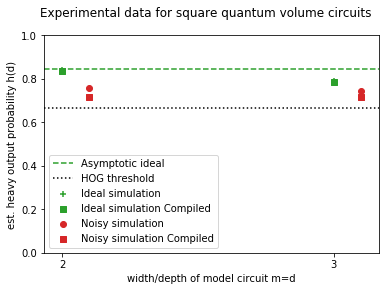

In [28]:
# Create a chart that is designed to look as similar as possible to
# Figure 2 in https://arxiv.org/pdf/1811.12926.pdf.

from matplotlib import pyplot as plt

fig, axs = plt.subplots()
for idx, sampler in enumerate(samplers):
    axs.scatter([d + idx / 10 for d in depths],
                sampler['probabilities'],
                marker=sampler['marker'],
                c=f"{sampler['color']}",
                label=f"{sampler['label']}")
    axs.scatter([d + idx / 10 for d in depths],
                sampler['compiled-probabilities'],
                marker="s",
                c=f"{sampler['color']}",
                label=f"{sampler['label']} Compiled")
# Line markers for asymptotic ideal heavy output probability and the ideal Heavy Output Generation threshold.
axs.axhline((1 + np.log(2)) / 2,
            color='tab:green',
            label='Asymptotic ideal',
            linestyle='dashed')
axs.axhline(2 / 3, label='HOG threshold', color='k', linestyle='dotted')
# Making the plot look consistent.
axs.set_ybound(0.0, 1)
axs.xaxis.set_major_locator(plt.MultipleLocator(1))
axs.set_xlabel("width/depth of model circuit m=d")
axs.set_ylabel("est. heavy output probability h(d)")
fig.suptitle('Experimental data for square quantum volume circuits')
axs.legend(loc='best')